# Data Processing for the House Price Kaggle Competition

My work has been inspired by the following kernels:

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#3.-Keep-calm-and-work-smart

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

https://www.kaggle.com/apapiu/regularized-linear-models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
train = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/train.csv')
test = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/test.csv')

In [3]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## Analyse Target ##

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


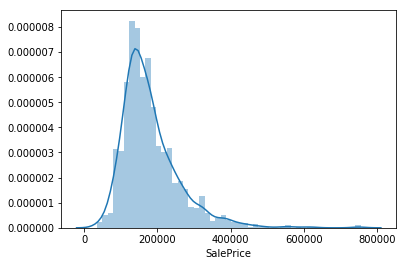

In [4]:
sns.distplot(train.SalePrice)

In [5]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
train.SalePrice.skew()

1.8828757597682129

In [7]:
train.SalePrice.isna().sum()

0

In [8]:
train.SalePrice.isnull().sum()

0

SalePrice is skewed to the right, will have to be normalised.

The maximum seems to be very far from 75% percentile, shows evidence of outliers.

No 0 value

No NA or null

## Missing Data ##

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
#y_train = train.SalePrice
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [10]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [11]:
def check_nas():    
    sample_values = pd.DataFrame(index=all_data.columns,columns=['SampleValue'])
    for i in all_data.columns:
        sample_values.loc[i].SampleValue = all_data[i].value_counts().index[1]
    nas = pd.DataFrame(all_data.isnull().sum(),columns=['SumOfNA'])
    types = pd.DataFrame(all_data.dtypes,columns=['Type'])
    sample_values.sort_index(inplace=True)
    nas.sort_index(inplace=True)
    types.sort_index(inplace=True)
    alls=pd.concat([sample_values,nas,types],axis=1)
    return(alls[alls.SumOfNA>0].sort_values('SumOfNA',ascending=False))

In [12]:
check_nas()

,SampleValue,SumOfNA,Type
PoolQC,Gd,2909,object
MiscFeature,Gar2,2814,object
Alley,Pave,2721,object
Fence,GdPrv,2348,object
FireplaceQu,TA,1420,object
LotFrontage,80,486,float64
GarageCond,Fa,159,object
GarageQual,Fa,159,object
GarageYrBlt,2006,159,float64
GarageFinish,RFn,159,object


In [13]:
# Most of the NAs are probably because the property does not contain the specific thing (eg. No Pool)
none_feats = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
              'GarageFinish','GarageQual','GarageType','GarageCond',
              'BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtQual',
              'BsmtCond','MasVnrType','MSZoning']
zero_feats = ['LotFrontage','GarageYrBlt','MasVnrArea']

In [14]:
for i in none_feats:
    all_data[i].fillna('None',inplace=True)

In [15]:
for i in zero_feats:
    all_data[i].fillna(0,inplace=True)

In [16]:
all_data.drop(['MasVnrArea','MasVnrType','Electrical'],axis=1,inplace=True)

In [17]:
check_nas()

,SampleValue,SumOfNA,Type
BsmtFullBath,1,2,float64
BsmtHalfBath,1,2,float64
Functional,Min2,2,object
Utilities,NoSeWa,2,object
BsmtFinSF1,24,1,float64
BsmtFinSF2,294,1,float64
BsmtUnfSF,384,1,float64
Exterior1st,MetalSd,1,object
Exterior2nd,MetalSd,1,object
GarageArea,576,1,float64


In [18]:
all_data['BsmtFullBath'].fillna(0,inplace=True)
all_data['BsmtHalfBath'].fillna(0,inplace=True)
all_data['Functional'].fillna('Typ',inplace=True)
all_data['Utilities'].fillna('AllPub',inplace=True)
all_data['BsmtFinSF1'].fillna(0,inplace=True)
all_data['BsmtFinSF2'].fillna(0,inplace=True)
all_data['BsmtUnfSF'].fillna(0,inplace=True)
all_data['Exterior1st'].fillna('VinylSd',inplace=True)
all_data['Exterior2nd'].fillna('VinylSd',inplace=True)
all_data['GarageArea'].fillna(0,inplace=True)
all_data['GarageCars'].fillna(0,inplace=True)
all_data['KitchenQual'].fillna('None',inplace=True)
all_data['SaleType'].fillna('WD',inplace=True)
all_data['TotalBsmtSF'].fillna(0,inplace=True)


In [19]:
check_nas()

,SampleValue,SumOfNA,Type


## Features Importance and Correlation

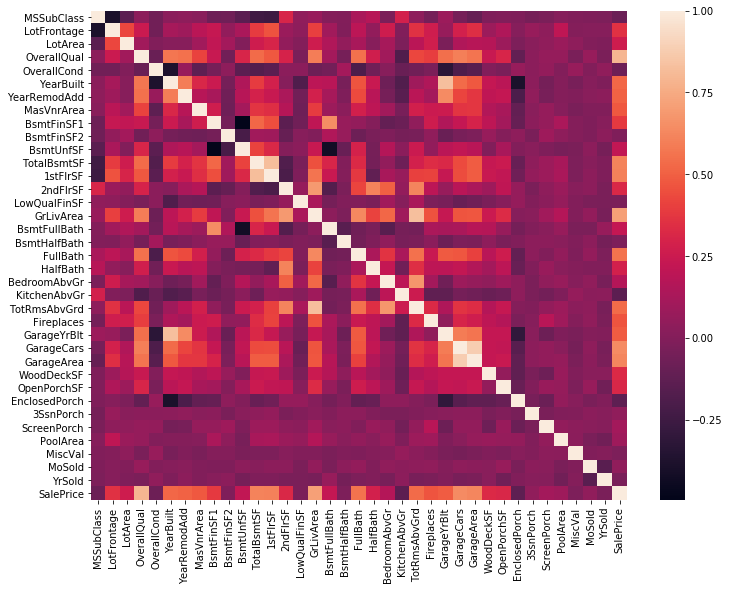

In [20]:
fig = plt.figure(figsize=(12,9))
sns.heatmap(train.corr())

In [21]:
imp_feat=abs(train.corr()['SalePrice']).sort_values(ascending=False).head(11).index

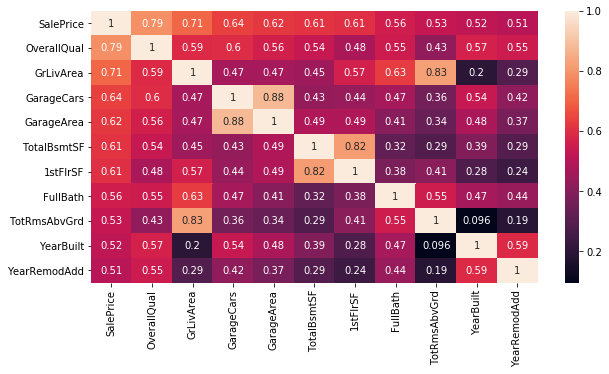

In [22]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(train[imp_feat].corr(),annot=True)

GarageCars and GarageArea very correlated --> keep GarageCars

TotalBsmtSF and 1stFlrSF very correlated --> keep TotalBsmtSF

GrLivArea and TotRmsAbvGrd very correlated --> keep GrLivArea

In [23]:
imp_feat_2 = imp_feat.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'])

In [24]:
# sub 5
all_data.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'],axis=1,inplace=True)

In [25]:
imp_feat_2

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
       'FullBath', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

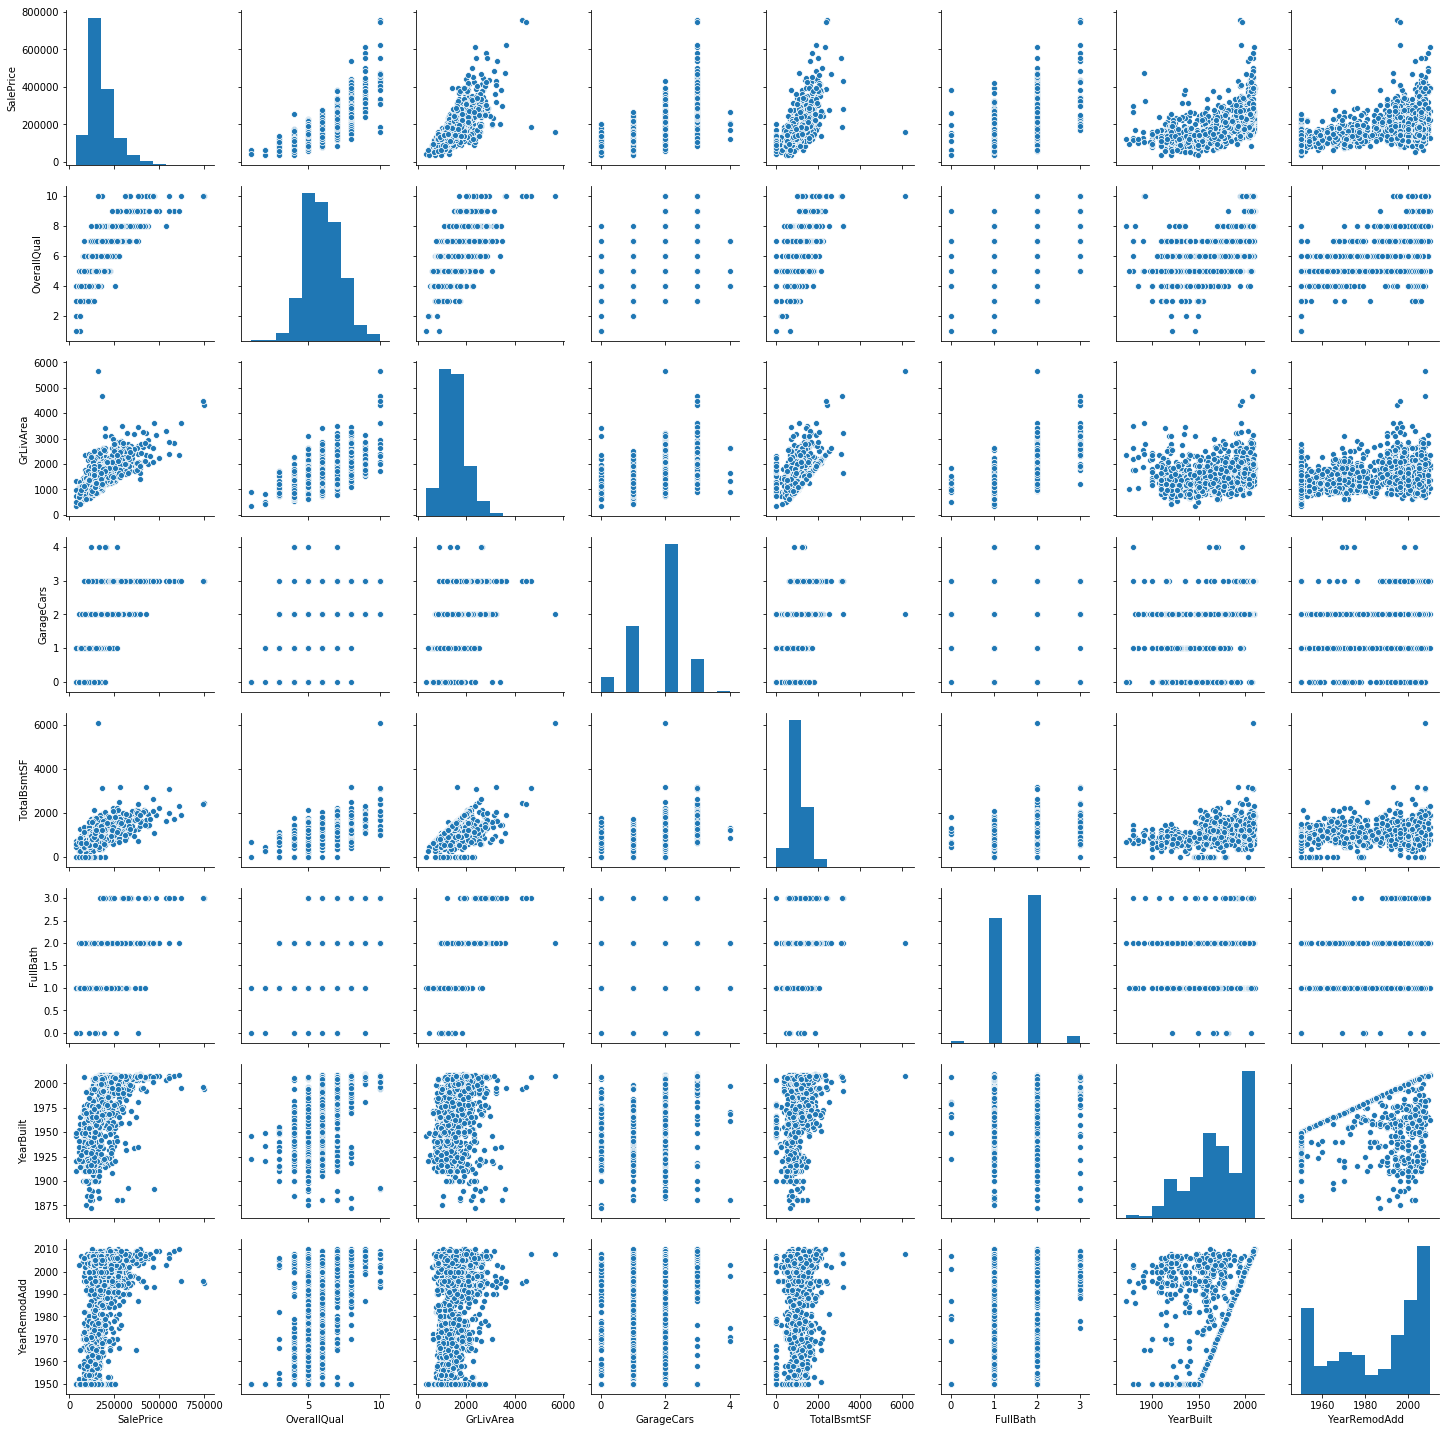

In [26]:
sns.pairplot(train[imp_feat_2])

## Outliars

We first see form the pairplot two outliars in SalePrice vs GrLivArea, let's identify and eliminate those

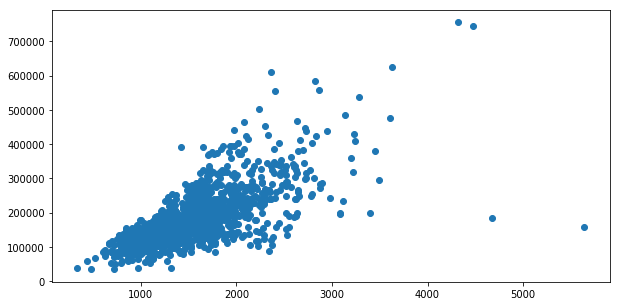

In [27]:
fig = plt.figure(figsize=(10,5))
plt.scatter(x=train.GrLivArea,y=train.SalePrice)

In [28]:
#train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
#all_data = all_data.drop(all_data[(all_data['GrLivArea']>4000) & (all_data['SalePrice']<300000)].index)

In [29]:
#fig = plt.figure(figsize=(10,5))
#plt.scatter(x=train.GrLivArea,y=train.SalePrice)

## Normalising Features and Target

In [30]:
x=abs(train[imp_feat_2].skew()).sort_values(ascending=False)
x

SalePrice       1.882876
TotalBsmtSF     1.524255
GrLivArea       1.366560
YearBuilt       0.613461
YearRemodAdd    0.503562
GarageCars      0.342549
OverallQual     0.216944
FullBath        0.036562
dtype: float64

In [31]:
def check_skew(column,with_log):
    feat = train[column]
    if (with_log==False):
        fig,ax = plt.subplots(figsize = (5,3))
        ax = sns.distplot(feat,fit=norm)
        fig,ax = plt.subplots(figsize = (5,3))
        ax = stats.probplot(feat, plot=plt)
        (mu, sigma) = norm.fit(feat)
        print( 'The normal dist fit has the following parameters: \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    elif (with_log==True):
        feat = np.log1p(feat)
        fig,ax = plt.subplots(figsize = (5,3))
        ax = sns.distplot(feat,fit=norm)
        fig,ax = plt.subplots(figsize = (5,3))
        ax = stats.probplot(feat, plot=plt)
        (mu, sigma) = norm.fit(feat)
        print( 'The normal dist fit has the following parameters: \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    

The normal dist fit has the following parameters: 
 mu = 180921.20 and sigma = 79415.29

The normal dist fit has the following parameters: 
 mu = 12.02 and sigma = 0.40



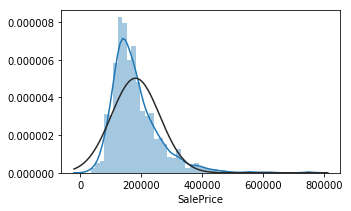

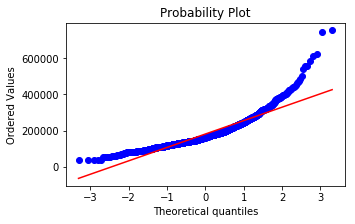

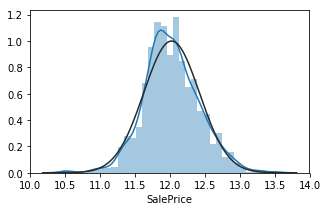

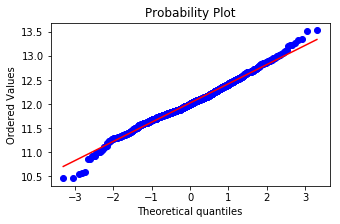

In [32]:
check_skew(column='SalePrice',with_log=False)
check_skew(column='SalePrice',with_log=True)

In [33]:
train['SalePrice'] = np.log1p(train['SalePrice'])

The normal dist fit has the following parameters: 
 mu = 1057.43 and sigma = 438.56

The normal dist fit has the following parameters: 
 mu = 6.75 and sigma = 1.15



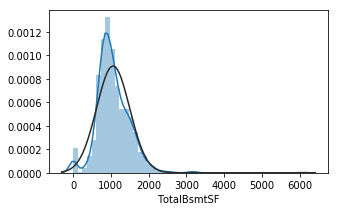

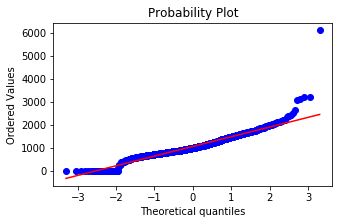

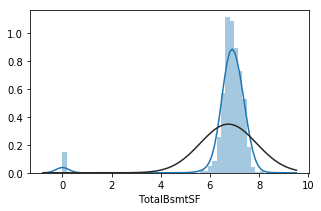

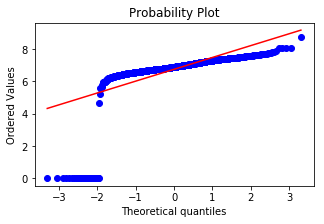

In [34]:
check_skew(column='TotalBsmtSF',with_log=False)
check_skew(column='TotalBsmtSF',with_log=True)

Zero values ruin log method, must not include them in log

In [35]:
all_data['TotalBsmtSF'][all_data['TotalBsmtSF']!=0] =  np.log1p(all_data['TotalBsmtSF'][all_data['TotalBsmtSF']!=0])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The normal dist fit has the following parameters: 
 mu = 1084.92 and sigma = 409.27



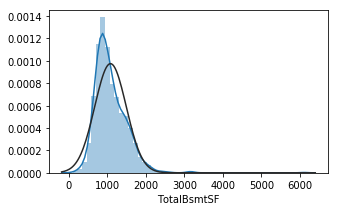

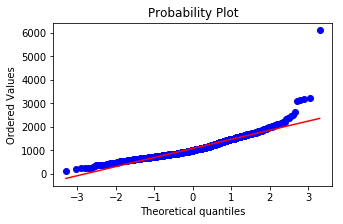

In [36]:
fig,ax = plt.subplots(figsize = (5,3))
ax = sns.distplot(train['TotalBsmtSF'][train['TotalBsmtSF']!=0],fit=norm)
fig,ax = plt.subplots(figsize = (5,3))
ax = stats.probplot(train['TotalBsmtSF'][train['TotalBsmtSF']!=0], plot=plt)
(mu, sigma) = norm.fit(train['TotalBsmtSF'][train['TotalBsmtSF']!=0])
print( 'The normal dist fit has the following parameters: \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

In [37]:
x=abs(train[imp_feat_2].skew()).sort_values(ascending=False)
x

TotalBsmtSF     1.524255
GrLivArea       1.366560
YearBuilt       0.613461
YearRemodAdd    0.503562
GarageCars      0.342549
OverallQual     0.216944
SalePrice       0.121347
FullBath        0.036562
dtype: float64

In [38]:
# for sub 5
#num_nonzero = list(set(all_data.dtypes[all_data.dtypes != "object"].index) & set([i for i in all_data.columns.values if sum(all_data[i]==0)==0]))
#skewed = abs(all_data[num_nonzero].skew()).sort_values(ascending=False)
#skewed_feats = skewed[skewed > 0.75].index
#all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [39]:
# for sub 4
#numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
#numeric_feats
#skewed_feats=abs(all_data[numeric_feats].skew()).sort_values(ascending=False)
#skewed_feats = skewed_feats[skewed_feats > 0.75].index
#all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [40]:
all_data = pd.get_dummies(all_data)

In [41]:
all_data.shape

(2919, 291)

# Principal Component Analysis

In [42]:
# sub 6
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#pca.fit(all_data)
#x_pca = pca.transform(all_data)
#x_pca = pd.DataFrame(x_pca, columns=['pca1','pca2'])

In [43]:
#all_data = pd.concat([all_data,x_pca],axis=1)

## Make X and y

In [44]:
y_train = train.SalePrice
train = all_data[:ntrain]
test = all_data[ntrain:]
train[train.GrLivArea >= 4600].index
y_train.drop(train[train.GrLivArea >= 4600].index,inplace=True)
train.drop(train[train.GrLivArea >= 4600].index,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
train.shape

(1458, 291)

In [46]:
test.shape

(1459, 291)

## Variance Threshold

## SelectKBest

# Modelling

In [56]:
train.to_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/train_final.csv',index=False)
y_train.to_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/y_train_final.csv',index=False,header=True)
test_ID.to_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/test_id.csv',index=False,header=True)
test.to_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/test_final.csv',index=False)

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [ ]:
X = train
y = y_train

In [ ]:
gb = make_pipeline(RobustScaler(), GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5))
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.5, random_state=1,max_iter=5000))
model_xgb = make_pipeline(RobustScaler(), xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
param_grid = {'learning_rate':[0.04,0.05,0.06],'max_depth':[2,4,6],
             'min_samples_leaf':[10,15,20],'min_samples_split':[5,10,15]}
search_gb = GridSearchCV(GradientBoostingRegressor(n_estimators=3000,loss='huber', random_state =5),
                       param_grid = param_grid
                       ,cv=3)
gb_pipe_search = make_pipeline(RobustScaler(),search_gb)

In [ ]:
param_grid = {'colsample_bytree':[3000,5000],'learning_rate':[0.04,0.05,0.06],'max_depth':[2,4,6]
             }
search_xgb =GridSearchCV(xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1),param_grid=param_grid,cv=3)
xgb_pipe_search = make_pipeline(RobustScaler(),search_xgb)

In [ ]:
param_grid = {'alpha':[0.0005,0.001,0.005],'l1_ratio':[0.3,0.5,0.9]}
search_enet = GridSearchCV(ElasticNet(random_state=3),param_grid=param_grid,cv=3)
enet_pipe_search = make_pipeline(RobustScaler(),search_enet)

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
# best sub 7 model
avg = AveragingModels(models = [gb, model_xgb, ENet])

In [ ]:
avg_search = AveragingModels(models = [gb_pipe_search, enet_pipe_search, xgb_pipe_search])

In [ ]:
def cross_val(model):
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    return(np.sqrt(-cross_val_score(model,X,y,scoring='neg_mean_squared_error',cv=kf)).mean())

In [ ]:
cross_val(lasso)

In [ ]:
cross_val(gb)

In [ ]:
#gb.fit(X,y)

In [ ]:
#mean_squared_error(gb.predict(X),y)

In [ ]:
avg.fit(X,y)

In [ ]:
mean_squared_error(avg.predict(X),y)

In [ ]:
avg_search.fit(X,y)

In [ ]:
mean_squared_error(avg_search.predict(X),y)

In [ ]:
#sub = pd.DataFrame()
#sub['Id'] = test_ID
#sub['SalePrice'] = np.expm1(avg.predict(test))
#sub.to_csv('submission7.csv',index=False)

In [ ]:
0.0028030795113756267